# 1. Introduction  

This notebook describes how to sovle the first problem `NodeBalance` in `CD2L-GM`, becasue $|V^s|>|V^t|$ in assumption 1.

`CD2L-GM` allows graph matching be applied across two independent graphs with the aim to transfer structral information from the source graph to the target graph. This approach helps with the graph learning on the target graph when it lacks structral information like nodes and edges [[2]](#refs). 

`CD2L-GM` illustrate a phenomenan that target graph $G^t = \{V^t,E^t\}$ lacks structural information while source graph $G^s = \{V^s,E^s\}$ is rich in structural inforamtion. Therefore, `CD2L-GM` is developed on the `FTLSIN` framework [[1]](#refs) with the following assumptions:  

1. $|V^s|>|V^t|$: The number of nodes in source graph is larger than the number of nodes in target graph.  
2. $|E^s|>|E^t|$: The number of edges in source graph is larger than the number of edges in target graph.  

**Note:** In `CD2L-GM`, assumption 2 ($|E^s|>|E^t|$) is redefined by $\langle deg^s \rangle > \langle deg^t \rangle$ which specifies the connection scale that the average node degree of source graph is larger than the average node degree of target graph.  

To address the problem of `NodeBalance`, the algorithm `CD2L-NodeBalance` described in this notebook tries to group the nodes in source graph so that the node scales in two graphs will be balanced to predict links between them. Specifically, the notebook demonstrates:  

1. Prepare source graph and target graph from dataset Cora.  
2. Initial clusters of source graph nodes and target graph nodes, where the nodes in a cluster have the same node degree. The clusters of source graph nodes are regarded as initial supernodes $V'^{(0)}$.
3. Three cases are considered: Case 1 for terminating `CD2L-NodeBalance`, Case 2 for merging supernodes, and Case 3 for splitting supernodes.
4. Objective function to meaure `CD2L-NodeBalance` and set a learning threshold.

**Note:** `CD2L-NodeBalance` corresponds to Section 4.1 in paper Cross-domain network representations [[2]](#refs).

<a name="refs"></a>
## References  

[1] Xue, Shan, Jie Lu, Guangquan Zhang, and Li Xiong. "A framework of transferring structures across large-scale information networks." 2018 International Joint Conference on Neural Networks (IJCNN). IEEE, 2018. ([link](https://ieeexplore.ieee.org/abstract/document/8489037))

[2] Xue, Shan, Jie Lu, and Guangquan Zhang. "Cross-domain network representations." Pattern Recognition 94 (2019): 135-148. ([link](https://www.sciencedirect.com/science/article/pii/S0031320319301852))

In [1]:
import os
import networkx as nx
import pandas as pd
import numpy as np
from itertools import chain
import collections
import math
from scipy.stats import linregress
import random

import matplotlib.pyplot as plt

**Choose a case to run the notebook**

In [2]:
case = 'merge'
# case = 'split'

# 2. Dataset  

The dataset is the citation network Cora. It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz). The following is the description of the dataset from the publisher:

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the **subject** attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`~/data/cora/`

where the files `cora.cites` and `cora.content` can be located.

We are going to load the data into a networkx object.

In [3]:
# data_dir = "~/data/cora"
data_dir = "~/Desktop/stellargraph/data/cora"

In [4]:
# load directed graph from ordering (cited_paper, citing_paper)
data_location = os.path.expanduser(data_dir)
g_nx = nx.read_edgelist(path=os.path.join(data_location,"cora.cites"), create_using=nx.DiGraph()).reverse()

# convert to undirected graph for processing
g_nx = g_nx.to_undirected()

# load the node attribute data
node_attr = pd.read_csv(os.path.join(data_location,"cora.content"), sep='\t', header=None)
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows() }
nx.set_node_attributes(g_nx, values, 'subject')

print("Graph statistics: {} nodes, {} edges".format(
    g_nx.number_of_nodes(), g_nx.number_of_edges()))

Graph statistics: 2708 nodes, 5278 edges


## 2.1 Data Preparation for Source and Target Graph  

We select the largest connected component as **Source Graph** and the second largest connected component as **Target Graph**.  

Case1: Data for Merge  
Case2: Data for Split

In [5]:
# For clarity we ignore isolated nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.v_no_s

g_nx_ccs = ( g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx) )

if case is 'merge':
    # Select the largest connected component as the source graph. 
    g_nx_s = max(g_nx_ccs, key=len)
    v_no_s = g_nx_s.number_of_nodes()
    print("Largest subgraph (source graph) statistics: {} nodes, {} edges".format(
        v_no_s, g_nx_s.number_of_edges()))
    
    # Select a smaller connected component as the target graph. 
    # Assumption one: target graph node scale < source graph node scale
    threshold = int(v_no_s / 10)
    print("Target graph number of nodes threshold: {}".format(threshold))
    
    g_nx_ccs_t = ( g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx) 
                  if g_nx.subgraph(c).copy().number_of_nodes() < threshold)
    g_nx_t = max(g_nx_ccs_t, key=len)
    v_no_t = g_nx_t.number_of_nodes()
    print("Smaller subgraph (target graph) statistics: {} nodes, {} edges".format(
        v_no_t, g_nx_t.number_of_edges()))
    
if case is 'split':
    # Select the largest connected component as the target graph. 
    g_nx_t = max(g_nx_ccs, key=len)
    v_no_t = g_nx_t.number_of_nodes()
    print("Largest subgraph (target graph) statistics: {} nodes, {} edges".format(
        v_no_t, g_nx_t.number_of_edges()))
    
    # Select a smaller connected component as the source graph. 
    threshold = int(v_no_t / 10)
    print("Source graph number of nodes threshold: {}".format(threshold))
    
    g_nx_ccs_s = ( g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx) 
                  if g_nx.subgraph(c).copy().number_of_nodes() < threshold)
    g_nx_s = max(g_nx_ccs_s, key=len)
    v_no_s = g_nx_s.number_of_nodes()
    print("Smaller subgraph (source graph) statistics: {} nodes, {} edges".format(
        v_no_s, g_nx_s.number_of_edges()))

Largest subgraph (source graph) statistics: 2485 nodes, 5069 edges
Target graph number of nodes threshold: 248
Smaller subgraph (target graph) statistics: 26 nodes, 43 edges


## 2.2 Degree Distribution of Source and Target Graphs

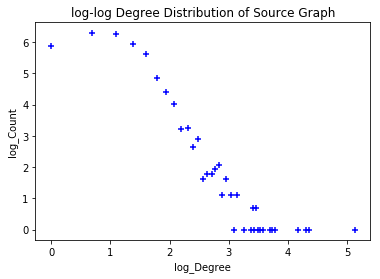

In [6]:
degree_sequence_s = sorted([d for n, d in g_nx_s.degree()], reverse=True)
degreeCount_s = collections.Counter(degree_sequence_s)
deg_s, cnt_s = zip(*degreeCount_s.items())
log_deg_s = [math.log(d) for d in deg_s]
log_cnt_s = [math.log(n) for n in cnt_s]

plt.scatter(log_deg_s, log_cnt_s, color='b', marker='+')
plt.title("log-log Degree Distribution of Source Graph")
plt.ylabel("log_Count")
plt.xlabel("log_Degree")

plt.show()

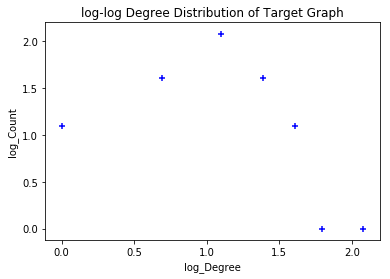

In [7]:
degree_sequence_t = sorted([d for n, d in g_nx_t.degree()], reverse=True)
degreeCount_t = collections.Counter(degree_sequence_t)
deg_t, cnt_t = zip(*degreeCount_t.items())
log_deg_t = [math.log(d) for d in deg_t]
log_cnt_t = [math.log(n) for n in cnt_t]

plt.scatter(log_deg_t, log_cnt_t, color='b', marker='+')
plt.title("log-log Degree Distribution of Target Graph")
plt.ylabel("log_Count")
plt.xlabel("log_Degree")

plt.show()

In [8]:
mean_deg_s = sum(degree_sequence_s)/len(degree_sequence_s)
mean_deg_t = sum(degree_sequence_t)/len(degree_sequence_t)
if mean_deg_s > mean_deg_t:
    print("Source graph and target graph are constructed.\n \
    Average Degree of Source Graph: {} > Average Degree of Target Graph: {}. \n \
    Node Size of Source Graph: {} > Node Size of Target Graph: {}. \
    ".format(mean_deg_s, mean_deg_t, v_no_s, v_no_t))
else:
    print("Fail in constructing source graph and target graph.\n \
    Average Degree of Source Graph: {} <= Average Degree of Target Graph: {}. \
    ".format(mean_deg_s, mean_deg_t))

Source graph and target graph are constructed.
     Average Degree of Source Graph: 4.0796780684104625 > Average Degree of Target Graph: 3.3076923076923075. 
     Node Size of Source Graph: 2485 > Node Size of Target Graph: 26.     


## 2.3 Dataset Summary  

| Graph | Number of Nodes  | Number of Edges | Average Degree |
|------|------|------|------|
|   Source Graph  | 2485 | 5069 | 4.080 |
|   Target Graph  | 26   | 43   | 3.308 |

# 3. Initialization of CD2L-NodeBalance Algorithm

## 3.1 Node Clusters of Target and Source Graphs  

The nodes are clustered by node degrees in `cluster_t` and `cluster_s`. 

In [9]:
deg_list_t = [d for n, d in g_nx_t.degree()]
nodeId_list_t = [n for n, d in g_nx_t.degree()]

# deg_t is the degree index get from box [6]
# generate a dict indexed by deg_t and wrap node IDs in same degree
cluster_t = {}
for deg in deg_t:
    cluster_t[str(deg)] = [nodeId_list_t[i] for i, x in enumerate(deg_list_t) if x == deg]

# print("Node clusters of target graph by degree: {}".format(cluster_t))

In [10]:
deg_list_s = [d for n, d in g_nx_s.degree()]
nodeId_list_s = [n for n, d in g_nx_s.degree()]

# deg_s is the degree index get from box [5]
# generate a dict indexed by deg_s and wrap node IDs in same degree
cluster_s = {}
for deg in deg_s:
    cluster_s[str(deg)] = [nodeId_list_s[i] for i, x in enumerate(deg_list_s) if x == deg]

# print("Node clusters of source graph by degree: {}".format(cluster_s))

## 3.2 Initial Node Degree Scales of Source and Target Graphs

`n_deg_t` and `n_deg_s` denote the degree scales of source and target graphs. `n_deg_t` and `n_deg_s` are also the initial numbers of clusters. 

In [11]:
n_deg_t = len(deg_t)
n_deg_s = len(deg_s)
print("Node degree scale of taret graph: {}".format(n_deg_t))
print("Initial node degree scale of source graph: {}".format(n_deg_s))

Node degree scale of taret graph: 7
Initial node degree scale of source graph: 37


## 3.3 Initial Weight Adjacency Matrix across Graphs

To batch matching the clusters across graphs, a target cluster will match to at least one source cluster. `group_size` describes the the number of cluster matches from one target cluster to multiple source clusters that `group_size`>=1. `overlap_size` defines the number of repetitions of the source clusters between two neighbor matches. `WM_cluster_cg_initial` is the **initial weight adjaceny matrix** across graphs for batch matching, where $i$ and $j$ refer to `cluster_t` and `cluster_s`, respectively.

In [12]:
n_deg_max = max(n_deg_s, n_deg_t)
n_deg_min = min(n_deg_s, n_deg_t)

group_size = n_deg_max - int(n_deg_max/n_deg_min) * (n_deg_min - 1)
overlap_size = group_size - int(n_deg_max/n_deg_min)
print("A target cluster link to {} source cluster with {} of overlaps with \
previous target cluster".format(group_size, overlap_size))

A target cluster link to 7 source cluster with 2 of overlaps with previous target cluster


Label clusters of source graph from 8 to 44.     Label clusters of target graph from 1 to 7.


/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


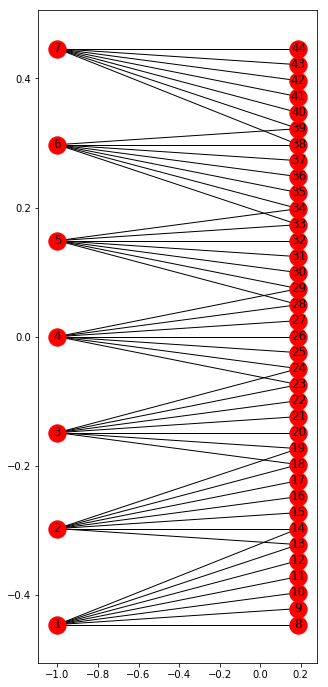

In [13]:
# cross-cluster edge set
if n_deg_s >= n_deg_t:
    E_cg = [[cluster_t_id + 1, (group_size - overlap_size) * cluster_t_id + correspond + n_deg_t + 1] \
            for cluster_t_id in range(n_deg_t)\
            for correspond in range(group_size)]
    g_nx_cg = nx.Graph()
    g_nx_cg.add_edges_from(E_cg)
    print("Label clusters of source graph from {} to {}. \
    Label clusters of target graph from 1 to {}.".format(n_deg_t+1,n_deg_s+n_deg_t,n_deg_t))
else:
    E_cg = [[(group_size - overlap_size) * cluster_s_id + correspond + 1, n_deg_t + cluster_s_id + 1] \
            for cluster_s_id in range(n_deg_s)\
            for correspond in range(group_size)]
    g_nx_cg = nx.Graph()
    g_nx_cg.add_edges_from(E_cg)
    print("Label clusters of target graph from 1 to {}. \
    Label clusters of source graph from {} to {}.".format(n_deg_t,n_deg_t+1,n_deg_t+n_deg_s))
    
plt.figure(1,figsize=(5,12)) 
graph_top = nx.bipartite.sets(g_nx_cg)[0]
graph_pos = nx.bipartite_layout(g_nx_cg,graph_top)
nx.draw_networkx(g_nx_cg,graph_pos)
plt.show()

In [14]:
## initial E_dic from initial E_cg
def link_dic_initial(E_cg):
    E_dic = {}
    for t_ind in np.unique(np.array(E_cg).T[0]):
        E_dic[t_ind] = (np.array(E_cg).T[1]-n_deg_t)[[i for i, x in enumerate(np.array(E_cg).T[0]) if x == t_ind]]
    return E_dic
E_dic = link_dic_initial(E_cg)

In [15]:
WM_cluster_cg_initial = np.zeros((n_deg_t,n_deg_s),dtype=np.float)
print("Size of weight adjacency matrix of cross graph clusters: {}".format(WM_cluster_cg_initial.shape))
for link in E_cg:
    start = link[0]-1
    end = link[1]-n_deg_t-1
    WM_cluster_cg_initial[start][end] = min(deg_t[start],deg_s[end])/max(deg_t[start],deg_s[end])

Size of weight adjacency matrix of cross graph clusters: (7, 37)


## 3.4 Initial Supernode of Source Graph

A `supernode` is a `bag` of nodes clustered by certain rules depends on algorithm requirements. In `CD2L-NodeBalance`, `supernode` only works on source graph. In initialization, a `supernode_initial` is a source graph cluster in `cluster_s`.

In [16]:
def get_node_id_to_ind(g_nx):
    v_id_to_ind = {}
    v = list(g_nx.node())
    for i in range(len(v)):
        v_id_to_ind[v[i]] = i + 1
    return v_id_to_ind 

v_s_id_to_ind = get_node_id_to_ind(g_nx_s)
v_t_id_to_ind = get_node_id_to_ind(g_nx_t)

In [17]:
# collect individual node attributes in one supernode
# return in a bag as supernode values
def node_attribute_in_supernode(node_bag,v_id_to_ind,g_nx):
    node_ids = [node_id for node_id in node_bag]
    node_inds = [v_id_to_ind[node_id] for node_id in node_bag]
    degrees = [g_nx.degree[node_id] for node_id in node_bag] 
    bag = {'node_ids': node_ids,
           'node_inds': node_inds,
           'node_degs': degrees,
           'supernode_deg': np.mean(degrees),
          }
    return bag

In [18]:
# initial supernode of source graph
# keys: supernode+no.(1-37)
# keys of each supernode: ['node_ids', 'node_inds', 'node_degs', 'supernode_deg', 'supernode_ind']
supernode_initial = {}
for deg, cnt in zip(cluster_s.keys(),range(1,len(cluster_s)+1)):
    node_bag = cluster_s[deg]
    supernode_initial["supernode{}".format(cnt)] = node_attribute_in_supernode(node_bag,v_s_id_to_ind,g_nx_s)

## 3.5 Initial Weight and Link Vectors across Graphs

`CD2L-NodeBalance` balances node scales across graphs by learning `supernode` for each node in target graph. At the same time, links are predicted across graphs between a node in target graph and a supernode in source graph according to their weights. Each link is saved in a vector `vec_e` and the same to a weight `vec_w`.

In [19]:
# index {node ind, target cluster ind, node degree} by target graph node id
def node_t_cluster_ind(cluster_t, v_t_id_to_ind):
    node_id_to_cluster_ind_t = {}
    for cnt, deg_str, node_id_set in zip(range(1,len(cluster_t)+1), cluster_t.keys(), cluster_t.values()):
        for node_id in node_id_set:
            node_id_to_cluster_ind_t[node_id] = {'node_t_ind': v_t_id_to_ind[node_id],
                                                 'cluster_t_ind': cnt,
                                                 'node_deg': int(deg_str)
                                                }
    return node_id_to_cluster_ind_t

node_id_to_cluster_ind_t = node_t_cluster_ind(cluster_t, v_t_id_to_ind)

In [20]:
# vector of weights across graph clusters of each target cluster in objective function
# a vector rooted at a node in target graph
# each element in the weight victor stand for the weight from a rooted node to a supernode in source graph
def weight_vector(node_id_t, WM_cluster_cg, node_id_to_cluster_ind_t):
    vec_w = WM_cluster_cg[node_id_to_cluster_ind_t[node_id_t]['cluster_t_ind']-1]
    return vec_w

# vec_w_initial = weight_vector('193352', WM_cluster_cg_initial, node_id_to_cluster_ind_t)

In [21]:
# vector of edges across graph clusters of each target cluster in objective function
def link_vector(vec_w):
    vec_e = [1 if w>0 else 0 for w in vec_w]
    return np.array(vec_e)

# vec_e_initial = link_vector(vec_w_initial)

# 4. Supernode Training: Merging and Splitting

The `supernode` training learns in batches. It ends when a target cluster match to unique supernode (Case 1), that is `group_size` == 1. Otherwise, when `group_size` > 1 (Case 2), `supernode_mearge` training starts; and `supernode_split` training starts when `group_size` < 1 (Case 3). `E_dic` is returned with supernode training which is a dictionary index by target cluster id and valued with supernode id.  

![CD2L-NodeBalance](nodebalance.png)  

**Note:** Here we overlap `supernode` between neighbor `CD2L-NodeBalance` matches. Therefore, `supernode_mearge` training ends at `group_size_min` == 2.

## 4.1 Supernode Merging

`supernode_mearge` works in batches. It returns updated `supernode` and `mearge` which saves the changes in `supernode` training.

In [22]:
# Case 2: n_supernode > n_deg_t (group_size > 1)
# merge neighbor supernode 

def supernode_ind_merge(supernode, window):
    size = [len(supernode['supernode{}'.format(i+1)]['node_ids']) for i in window]
    ind_merge = window[size.index(min(size))]
    if ind_merge == window[-1]: ind_receive = ind_merge - 1 
    else: ind_receive = ind_merge + 1
    return ind_merge+1, ind_receive+1

def supernode_mearge(n_deg_t, supernode, group_size_min, WM_cluster_cg):
    n_sn = len(supernode)
    merge = []
    for cluster_t_i in range(n_deg_t):
        window = [n for n,i in enumerate(WM_cluster_cg[cluster_t_i]) if i>0]
        if len(window) < group_size_min: group_size_min = len(window)
        # the first smallest supernode in window merge to next/previous supernode
        ind_m, ind_r = supernode_ind_merge(supernode, window)
        merge.append([ind_m, ind_r])
        print('-------- merging supernode {} -> supernode {}'.format(ind_m, ind_r))
        sn_m = supernode['supernode{}'.format(ind_m)]
        sn_r = supernode['supernode{}'.format(ind_r)]
        n_v_m, n_v_r = len(sn_m['node_ids']), len(sn_r['node_ids'])
        # merge everything keys=['node_ids','node_inds','node_degs','supernode_deg','supernode_ind']
        # node(append list): 'node_ids', 'node_inds', 'node_degs'
        for node_id, ind, deg in zip(sn_m['node_ids'], sn_m['node_inds'], sn_m['node_degs']):
            sn_r['node_ids'].append(node_id)
            sn_r['node_inds'].append(ind)
            sn_r['node_degs'].append(deg)
        sn_r['supernode_deg'] = (sn_r['supernode_deg']*n_v_r+sn_m['supernode_deg']*n_v_m)/(n_v_r+n_v_m)
        del supernode['supernode{}'.format(ind_m)]
    new_keys = ['supernode{}'.format(i+1) for i in range(len(supernode))]
    for key, new_key in zip(list(supernode.keys()),new_keys):
        supernode[new_key] = supernode.pop(key)
    print('---- Number of supernodes: {} -> {}. Group size: {} -> {}.'.format(
        n_sn,len(supernode),group_size,group_size-1))
    return supernode, merge, group_size_min

# supernode, merge = supernode_mearge(n_deg_t, supernode_initial, group_size, WM_cluster_cg_initial)

## 4.2 Supernode Splitting

`supernode_split` works in batches. It returns updated `supernode` and `split` which saves the changes in `supernode` training.

In [23]:
# Case 3: n_supernode < n_deg_t
# split neighbor supernode 

def split_random(supernode, WM_cluster_cg):
    # output: new_match = {cluster_t_ind: node_location_ind (start from 0) in supernode}
    match = {}
    for j, col in enumerate(WM_cluster_cg.T):
        new_match={}
        sn_ind = j + 1 # supernode ind
        window = [i+1 for i,x in enumerate(col) if x > 0] # sn_ind supernode matches to cluster_t_inds
        n_sn = len(supernode['supernode{}'.format(sn_ind)]['node_ids']) # may have overlap_size supernodes in maximum
        # new_match = {n_sn > 1} otherwise {}
        # 1. Node size in supernode >= 1 and matching window size = 1. Don't need to split.
        # 2. Node size in supernode = 1 and matching window size is > 1. Repeat matching the same supernode.
        # 3. Node size in supernode > 1 and matching window size = Node size in supernode. Random a 1-to-1 match.
        # 4. Node size in supernode > 1 and matching window size > Node size in supernode. 
        #    Random repeat some nodes to meet a 1-to-1 match.'
        # 5. Node size in supernode > 1 and matching window size < Node size in supernode. 
        #    Random select some nodes to meet a 1-to-1 match.')
        if n_sn > 1:
            candi = list(range(n_sn))
            random.shuffle(candi)
            if len(window) < n_sn:
                n = math.ceil(n_sn/len(window))
                candi += candi
            for i,ind in enumerate(window):
                if len(window) >= n_sn:
                    if i < n_sn:
                        new_match[ind] = [candi[i]]
                    else:
                        new_match[ind] = [random.randint(0,n_sn-1)]
                else:
                    new_match[ind] = candi[i*n:(i+1)*n]
        match['supernode{}'.format(sn_ind)] = {'match': new_match, 'window': window}
    print("match result: {}".format(match))
    return match

def supernode_split(supernode, WM_cluster_cg):
    # output: supernode_new: update keys and values; split: {old_sn_ind: new_sn_ind}; group_size_min = 1
    match = split_random(supernode, WM_cluster_cg)
    supernode_new = {}
    split = {i+1: [] for i,key in enumerate(match.keys())}
    sn_new_cnt = 1
    for sn_ind, sn_match in zip(match.keys(),match.values()):
        if not sn_match['match']:
            for cluster_t_ind in sn_match['window']:
                supernode_new['supernode{}'.format(sn_new_cnt)] = supernode[sn_ind]
                split[int(sn_ind.replace('supernode', ''))] += [sn_new_cnt]
                sn_new_cnt += 1
        else:
            for sn_n_inds in sn_match['match'].values():
                node_ids = [supernode[sn_ind]['node_ids'][loc] for loc in sn_n_inds]
                node_inds = [supernode[sn_ind]['node_inds'][loc] for loc in sn_n_inds]
                supernode_new['supernode{}'.format(sn_new_cnt)] = {'node_ids': node_ids,
                                                                   'node_inds': node_inds,
                                                                   'supernode_deg': np.mean(node_inds)
                                                                  }
                split[int(sn_ind.replace('supernode', ''))] += [sn_new_cnt]
                sn_new_cnt += 1
    group_size_min = 1
    print("split results: {}".format(split))
    print("minimum group_size: {}".format(group_size_min))
    return supernode_new, split, group_size_min

# supernode, split, group_size_min = supernode_split(supernode_initial, WM_cluster_cg_initial)

## 4.3 Update Links across Graph Clusters

`link_dic_merge` and `link_dic_split` reports cross graph links on clusters along with `supernode_mearge` or `supernode_split` and return `E_dic`.

In [24]:
## update E_dic acording to merge result
def link_dic_merge(E_dic,merge):
    receiving_set = list(np.array(merge).T[1])
    merging_set = list(np.array(merge).T[0])
    for sn in receiving_set:
        if sn in merging_set:
            loc_r = receiving_set.index(sn)
            loc_m = merging_set.index(sn)
            merge[loc_r][1] = merge[loc_m][1]        
    # for example, merge [8->9] [9->10] will be updated as [8->10] [9->10]
    for key in E_dic.keys():
        for mr in merge:
            if mr[0] in E_dic[key]: E_dic[key][list(E_dic[key]).index(mr[0])] = mr[1]
        E_dic[key] = np.unique(E_dic[key])
    inds = np.unique(sorted(set(chain(*E_dic.values()))))
    ind_to_newind = dict(zip(inds,range(1,len(inds)+1)))
    for key,value in zip(E_dic.keys(),E_dic.values()):
        E_dic[key] = [ind_to_newind[x] for x in value]
    return E_dic
# E_dic = link_dic_merge(E_dic,merge)

In [25]:
## update E_dic acording to split result
def link_dic_split(E_dic,split):  
    for key,value in zip(E_dic.keys(),E_dic.values()):
        for i,x in enumerate(value):
            E_dic[key][i] = split[x][0]
            del split[x][0]
        E_dic[key] = list(E_dic[key])
    return E_dic
# E_dic = link_dic_split(E_dic,split)

## 4.4 Update Weight Adjacency Matrix across Graph Clusters

`cg_weight_matrix_update` returns `WM_cluster_cg` every time `supernode_mearge` or `supernode_split` happens.

In [26]:
# update WM_cluster_cg 
def cg_weight_matrix_update(supernode,E_dic,deg_t):
    WM_cluster_cg = np.zeros((len(E_dic),len(supernode)),dtype=float)
    print("---- Size of weight adjacency matrix of cross graph clusters: {}".format(WM_cluster_cg.shape))
    for key, value in zip(E_dic.keys(),E_dic.values()):
        for j in value:
            WM_cluster_cg[key-1][j-1] = \
            min(deg_t[key-1],supernode['supernode{}'.format(j)]['supernode_deg']) / \
            max(deg_t[key-1],supernode['supernode{}'.format(j)]['supernode_deg']) 
    return WM_cluster_cg
# WM_cluster_cg = cg_weight_matrix_update(supernode,E_dic,deg_t)

## 4.5 Objective Function

In objective function calculated by `obj_main`, power-law slope ratio across graphs `slope_cg` is a fix quantify, `eta` is updated in each iteration by `obj_eta`, and `C`, `Gamma` and `Lambda` are parameters.  

In [27]:
# power-law slope ratio a_plus in objective function
slope_s = linregress(log_deg_s, log_cnt_s)[0]
slope_t = linregress(log_deg_t, log_cnt_t)[0]
slope_cg = min(slope_s, slope_t)
print("Power-law slope ratio of source graph on degrees: {}".format(slope_s))
print("Power-law slope ratio of target graph on degrees: {}".format(slope_t))
print("Power-law slope ratio across graphs: {}".format(slope_cg))

Power-law slope ratio of source graph on degrees: -1.8684146795338967
Power-law slope ratio of target graph on degrees: -0.6192288646743601
Power-law slope ratio across graphs: -1.8684146795338967


In [28]:
# eta in objective function
def obj_eta(Gamma, Lambda, WM_cluster_cg):
    eta = 1/WM_cluster_cg.shape[0]*math.exp((1-math.pow(WM_cluster_cg.shape[1],2))/\
                                            WM_cluster_cg.shape[1])*Gamma*math.exp(Lambda)
    return eta

In [29]:
# objective function
# parameters: C, Gamma, Lambda
def obj_main(g_nx_t,slope_cg,WM_cluster_cg,node_id_to_cluster_ind_t,supernode,C):
    h = 0
    w, e = [], []
    eta = obj_eta(Gamma, Lambda, WM_cluster_cg)
    for node_id_t in g_nx_t.nodes():
        vec_w = weight_vector(node_id_t, WM_cluster_cg, node_id_to_cluster_ind_t)
        vec_e = link_vector(vec_w)
        h += math.log(C) - slope_cg*math.log(sum(vec_w*vec_w))
        w.append(list(vec_w))
        e.append(list(vec_e))
    h *= eta
    return h, w, e

# 5. Node Balance Training

`CD2L-NodeBalance` training ends at unique cluster match `WM_cluster_cg.shape[1]` == `n_deg_t` or objetive function is optimized `h` <= `H[-1]`.

In [30]:
## parameters
C=1
Gamma=10
Lambda=1

## initial
iteration = 0
supernode = supernode_initial
WM_cluster_cg = WM_cluster_cg_initial
n_deg_t = WM_cluster_cg.shape[0]
h, _, _ = obj_main(g_nx_t,slope_cg,WM_cluster_cg,node_id_to_cluster_ind_t,supernode,C)
H = [0, h]
group_size_min = WM_cluster_cg.shape[1]

## train
while group_size_min > 3:
    if n_deg_t > n_deg_s: # split supernode
        # update supernode by split
        print(">>>>> splitting supernodes <<<<<")
        supernode, split, group_size_min = supernode_split(supernode, WM_cluster_cg)
        # update cg link dic
        E_dic = link_dic_split(E_dic,split)
        C /= 100
    
    if n_deg_t < n_deg_s: # merge supernode
        iteration += 1
        print(">>>>> merge iteration {} <<<<<".format(iteration))
        # update supernode by merge
        supernode, merge, group_size_min = supernode_mearge(n_deg_t, supernode, group_size, WM_cluster_cg)
        print("supernodes: {}".format(supernode.keys()))
        # update cg link dic
        E_dic = link_dic_merge(E_dic,merge)
        C *= 100
    
    # update cg cluster weight matrix
    WM_cluster_cg = cg_weight_matrix_update(supernode,E_dic,deg_t)
    # estimate objective function
    h, w, e = obj_main(g_nx_t,slope_cg,WM_cluster_cg,node_id_to_cluster_ind_t,supernode,C)
    print("---- h = {}".format(h))
    if h>H[-1]: H.append(h) 
    else: break
del H[0]

# return and save w,e
# line: node_ind of target graph; column: supernode_ind of source graph
if n_deg_t > n_deg_s: # split supernode
    np.savez('cora_NodeBalance_result_split_case', weight=w, edge=e, supernode=supernode)
if n_deg_t < n_deg_s: # merge supernode
    np.savez('cora_NodeBalance_result_merge_case', weight=w, edge=e, supernode=supernode)

>>>>> merge iteration 1 <<<<<
-------- merging supernode 1 -> supernode 2
-------- merging supernode 6 -> supernode 7
-------- merging supernode 12 -> supernode 13
-------- merging supernode 17 -> supernode 18
-------- merging supernode 25 -> supernode 26
-------- merging supernode 27 -> supernode 28
-------- merging supernode 31 -> supernode 32
---- Number of supernodes: 37 -> 30. Group size: 7 -> 6.
supernodes: dict_keys(['supernode1', 'supernode2', 'supernode3', 'supernode4', 'supernode5', 'supernode6', 'supernode7', 'supernode8', 'supernode9', 'supernode10', 'supernode11', 'supernode12', 'supernode13', 'supernode14', 'supernode15', 'supernode16', 'supernode17', 'supernode18', 'supernode19', 'supernode20', 'supernode21', 'supernode22', 'supernode23', 'supernode24', 'supernode25', 'supernode26', 'supernode27', 'supernode28', 'supernode29', 'supernode30'])
---- Size of weight adjacency matrix of cross graph clusters: (7, 30)
---- h = 2.3993595585783115e-11
>>>>> merge iteration 2 <<<<

# 6. Visualize Final Matching

H from iteration 1 to iteration 5: [-1.615453251118348e-14, 2.3993595585783115e-11, 7.147999322104025e-08, 0.00012817505675103476, 0.20353409931306574]



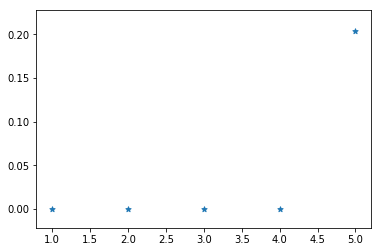

In [31]:
if len(H) > 1:
    print("H from iteration 1 to iteration {}: {}\n".format(len(H),H))
    plt.scatter(range(1,len(H)+1),H, label= "H", marker= "*", s=30)
    plt.show()
else: 
    print("H = {}".format(H[0]))

In [32]:
print("Final cross graph links between target cluster to source supernode: \n {}".format(E_dic))

Final cross graph links between target cluster to source supernode: 
 {1: [1, 2], 2: [2, 3, 4], 3: [3, 4], 4: [4, 5], 5: [5, 6], 6: [6, 7], 7: [7, 8, 9]}


Label supernodes of source graph from 1 to 9. Label clusters of target graph from 10 to 16.


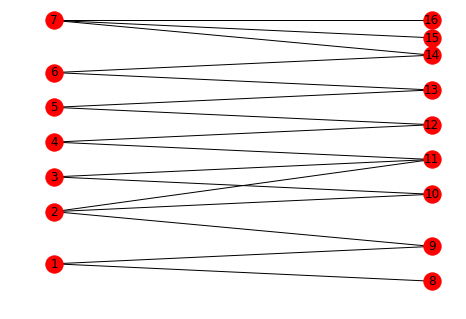

In [33]:
c_s = list(range(1,max(max(E_dic.values()))+1))
c_t = list(E_dic.keys())
E_cg = [[t_i,s_i+len(c_t)] for t_i in c_t for s_i in E_dic[t_i]]
df = pd.DataFrame(
    {'supernode': np.array(E_cg).T[1],
     'target_cluster': np.array(E_cg).T[0]})

g_nx_cg = nx.Graph()
g_nx_cg.add_nodes_from(df['supernode'], bipartite=1)
g_nx_cg.add_nodes_from(df['target_cluster'], bipartite=0)
g_nx_cg.add_edges_from([(row['target_cluster'], row['supernode']) for idx, row in df.iterrows()])
print("Label supernodes of source graph from 1 to {}. \
Label clusters of target graph from {} to {}.".format(len(c_s),len(c_s)+1,len(c_t)+len(c_s)))

if case is 'split':
    plt.figure(1,figsize=(5,14))
pos = {node:[0, i] for i,node in enumerate(df['target_cluster'])}
pos.update({node:[1, i] for i,node in enumerate(df['supernode'])})
nx.draw(g_nx_cg, pos, with_labels=False)
nx.draw_networkx_labels(g_nx_cg, pos)

plt.show()